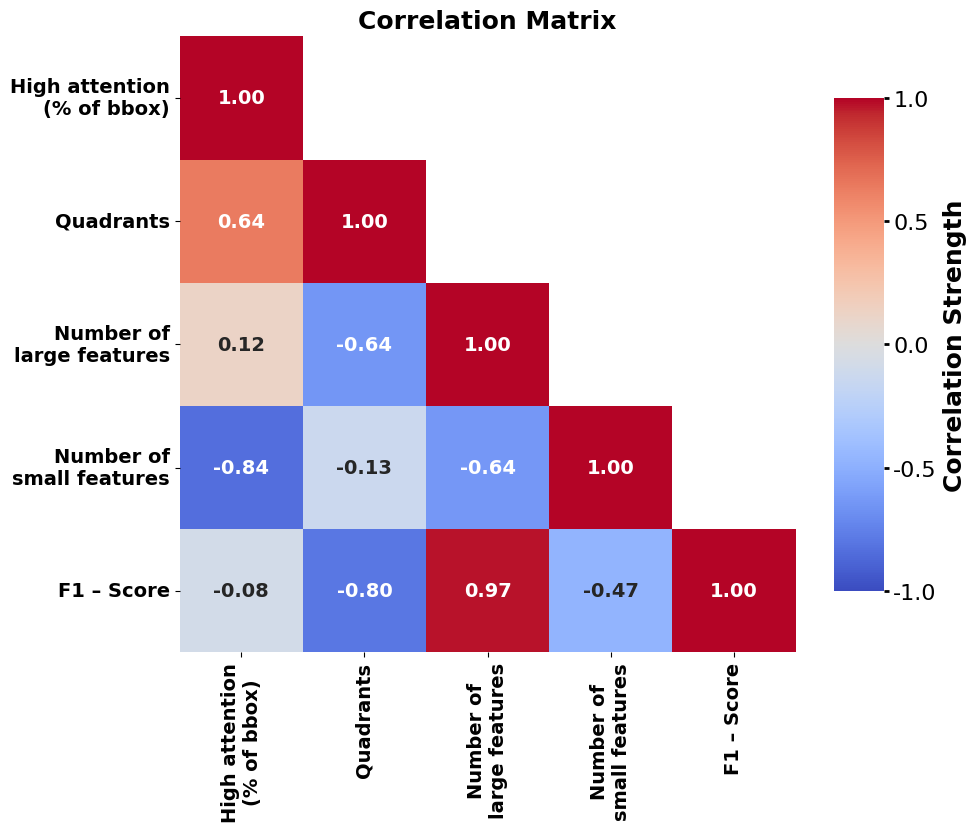

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

file_path = 'DETR_results_feature_analysis/features_data.txt'

with open(file_path, 'r') as file:
    data = file.readlines()

model_data = {}
current_model = None

for line in data:
    line = line.strip()
    
    # Check if the line is a model name
    if re.match(r'^[A-Za-z0-9_]+:$', line):
        current_model = line[:-1]
        model_data[current_model] = {}
    
    # Extract and parse relevant data
    if 'Average high attention value' in line:
        model_data[current_model]['High attention\n(% of bbox)'] = float(line.split(": ")[1])
    elif 'Average number of quadrants' in line:
        model_data[current_model]['Quadrants'] = float(line.split(": ")[1])
    elif 'Average number of big features' in line:
        model_data[current_model]['Number of\nlarge features'] = float(line.split(": ")[1])
    elif 'Average number of small features' in line:
        model_data[current_model]['Number of\nsmall features'] = float(line.split(": ")[1])

df = pd.DataFrame.from_dict(model_data, orient='index')

# Mean F1 Score calculated by testing the models on the real test video
f1_scores = {
    "Real1": 0.85, "Real2": 0.85, "Real3": 0.85,
    "Storage_Box1": 0.73, "Storage_Box2": 0.73, "Storage_Box3": 0.73,
    "SD_V1_1": 0.67, "SD_V1_2": 0.67, "SD_V1_3": 0.67,
    "SD_V2_1": 0.74, "SD_V2_2": 0.74, "SD_V2_3": 0.74
}

# Add the F1 Score column to the DataFrame
df['F1 – Score'] = df.index.map(f1_scores)

# Grouping models into categories
groups = {
    "Real": ["Real1", "Real2", "Real3"],
    "Storage_Box": ["Storage_Box1", "Storage_Box2", "Storage_Box3"],
    "SD_V1": ["SD_V1_1", "SD_V1_2", "SD_V1_3"],
    "SD_V2": ["SD_V2_1", "SD_V2_2", "SD_V2_3"]
}

# Calculate the mean values for each group
group_means = {}
for group_name, model_list in groups.items():
    group_df = df.loc[model_list]
    group_mean = group_df.mean(numeric_only=True)
    group_means[group_name] = group_mean

group_means_df = pd.DataFrame(group_means).T

corr_matrix = group_means_df.corr()

# Create a mask for the upper triangle (excluding the diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f',
                      mask=mask, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns,
                      annot_kws={"size": 14, 'weight': 'bold'},
                      cbar_kws={'label': 'Correlation Strength', 'shrink': 0.8, 'aspect': 10},
                      square=True)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=14, weight='bold', rotation=90)
plt.yticks(fontsize=14, weight='bold', rotation=0)

cbar = heatmap.collections[0].colorbar
num_ticks = len(cbar.get_ticks())
selected_ticks = cbar.get_ticks()[::2]

cbar.set_ticks(selected_ticks)
cbar.set_ticklabels([f'{tick:.1f}' for tick in selected_ticks])
cbar.ax.yaxis.set_tick_params(labelsize=16, width=2)
cbar.set_label('Correlation Strength', fontsize=18, weight='bold')

# Add a title with larger font and bold text
plt.title("Correlation Matrix", fontsize=18, weight='bold')
plt.show()
